# Title: Graph Embeddings
## Purpose: Explore ML on graphs, networks, etc
## @author: mjz

## Background




In [1]:
%matplotlib inline

#------ python libs ----------
import logging
import os
SEP = os.path.sep
import sys
import uuid
import pathlib

#------ notebook libs ----------
import matplotlib.pyplot as plt
import networkx as nx
import graphviz
import IPython.display
import numpy as np
# import scipy.stats as st
# import scipy.special
# # bokeh plotting setup
# import bokeh.io
# import bokeh.plotting
# import bokeh.application
# import bokeh.application.handlers
# bokeh.io.output_notebook()
# notebook_url = 'localhost:8888'

import os
from google.cloud import bigquery
%reload_ext google.cloud.bigquery

import pandas as pd
import pandas_gbq


#------ project libs ----------
py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

# Just importing for their flags right now
import py_mulval.py_mulval as py_mulval
import py_mulval.boromir as boromir
import py_mulval.log_util as log_util
import py_mulval.mulpy as mulpy
import py_mulval.metrics as secmet
import py_mulval.attack_graph as attack_graph
from py_mulval.mulval_fact_graph import FactGraph
from py_mulval.attack_graph import AttackGraph

from py_mulval import flags
FLAGS = flags.FLAGS
FLAGS([sys.argv[0]]) # dont expect cli args from jupyter

['/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/ipykernel_launcher.py']

In [2]:
# Show an dot graph in this notebook
def plot_dot(ag, title=None):
    A = nx.nx_agraph.to_agraph(ag)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

# from IPython.display import Image, display
# def plot_dot(pdot):
#     plt = Image(pdot.create_png())
#     display(plt)

## Assumptions

In [3]:
# %%bash
# /opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

## Setup

We can run boromir with the following command:

`./run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'`

mttf.yml:
```
mttf:
    flags:
        # secmet_score_strategy: 'reliability'
        secmet_plot_intermediate_graphs: False
        secmet_random_cvss_score: True
```

Using the mttf.yml file helps us track runs with version control systems, but all flags can be specified at the command line as well. `--secmet_random_cvss_score=True` and `--boromir_run_count=1000` create 1000 samples with vulnerability scores chosen from a uniform random distribution in `[0.0, 10.0]` to represent a CVSS score. Other distributions and intervals can be defined as well.

The flag `--bigquery_table='cloud-performance-tool:test_notebook_bq.test1'` tells boromir where to publish the results. If no publishing target is specified the results are stored as json in the $TMP directory. Influxdb setup is covered in notebook `000_influxdb_setup.ipynb`.



In [4]:
# %%bash
# /opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

In [5]:
%%bigquery df
# SELECT thedate, sample_uri, test, value, metric,
SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph,
metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,

  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
    and run_uri = 'efcc5190'
#      order by timestamp asc
#      limit 1
     ) 

In [6]:
%%bigquery
SELECT * FROM `cloud-performance-tool.test_notebook_bq.test1`
where labels != ''
limit 5

,sample_uri,run_uri,owner,official,timestamp,unit,test,product_name,value,labels,metric
0,dd089141-8b34-4cc6-94ea-9b6ace05910d,baf7cd41,cat-dog,False,1.588540e+09,weeks,mttf,py_mulval,50.420199,|attack_graph_orig:digraph single_host_1 {\n\t...,mttf
1,32d10687-767c-4939-a105-3497e6a5bce5,baf7cd41,cat-dog,False,1.588540e+09,weeks,mttf,py_mulval,100.001399,|attack_graph_orig:digraph single_host_1 {\n\t...,mttf
2,467be8de-d458-4f45-9136-ecf5cb0186e4,baf7cd41,cat-dog,False,1.588540e+09,weeks,mttf,py_mulval,55.000400,|attack_graph_orig:digraph single_host_1 {\n\t...,mttf
3,7c44d67d-dd8a-48f6-a1ee-f2470f837063,baf7cd41,cat-dog,False,1.588540e+09,weeks,mttf,py_mulval,11.020000,|attack_graph_orig:digraph single_host_1 {\n\t...,mttf
4,9a61bde6-fd9f-4f67-943d-2be66e578cfa,baf7cd41,cat-dog,False,1.588540e+09,weeks,mttf,py_mulval,50.240120,|attack_graph_orig:digraph single_host_1 {\n\t...,mttf


Most of the details we'll need for ML are captured in the metadata field `labels`. 

We can extract the interesting fields into a pandas dataframe as follows:


In [7]:
# %%bigquery df

# #standardSQL
# SELECT thedate, sample_uri, test, value, unit, metric, run_uri,
# -- citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# attack_graph, transition_matrix, transition_matrix_raw,
# labels
# FROM (
#   SELECT
# #     value,
#     TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
#     test, value, unit, labels,metric, sample_uri, run_uri,
#     REGEXP_EXTRACT(labels, r'(?s)\|citation:(.*?)\|') AS citation,
#     REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
#     REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
#     REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
#     REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
#     REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS attack_graph,
#     REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix:(.*?)\|') AS transition_matrix,
#     REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix_raw:(.*?)\|') AS transition_matrix_raw,
    
#   FROM
#     `cloud-performance-tool.test_notebook_bq.test1`
#    WHERE
#      test = 'mttf'
#      AND metric = 'mttf' 
#      and run_uri = 'efcc5190'
#      )

In [8]:
df.head()

,sample_uri,reduced_ag,value,orig_ag,fact_graph,metric
0,f3c1b87e-cad1-431f-ac63-eac72b694c84,digraph single_host_1 {\n\tgraph [name=single_...,4.00,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
1,0514df06-4242-451a-b737-41057c26dc00,digraph single_host_1 {\n\tgraph [name=single_...,12.00,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
2,a6c94818-2807-484a-83c5-d2f227a37a45,digraph single_host_1 {\n\tgraph [name=single_...,16.00,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
3,8b265a5c-f662-42fd-a8a1-f084ef4a66e1,digraph single_host_1 {\n\tgraph [name=single_...,0.75,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
4,9dc8f994-84a6-40d4-ae6d-bf1cfdba007d,digraph single_host_1 {\n\tgraph [name=single_...,40.50,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf


In [9]:
df[df['metric']=='mttf'].describe()

,value
count,1000.000000
mean,36.107870
std,35.488545
min,0.020600
25%,5.258434
50%,32.310100
75%,55.170250
max,191.833333


In [10]:
df[df['metric']=='mttf'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
sample_uri    1000 non-null object
reduced_ag    1000 non-null object
value         1000 non-null float64
orig_ag       1000 non-null object
fact_graph    1000 non-null object
metric        1000 non-null object
dtypes: float64(1), object(5)
memory usage: 54.7+ KB


We can see how these values fall within our experimental range by fixing the lower and upper bounds of security for this topology with the following configuration (`mttf_step_cvss.yml`):

```
mttf:
    flag_matrix: fmatrix
    flag_matrix_defs:
        fmatrix:
            secmet_fix_cvss_score: [1, 2, 3, 4, 5, 6,  7, 8, 9, 10]
    flags:
        secmet_plot_intermediate_graphs: False
        secmet_map_scores: 'cvss2time'
```

In [11]:
# %%bash
# /opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf_step_cvss.yml --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

In [12]:
%%bigquery df_fixed_cvss

#standardSQL
SELECT thedate, test, value, unit, metric,
-- citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
attack_graph, transition_matrix, transition_matrix_raw, fix_cvss_score,
labels
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels,metric, 
    REGEXP_EXTRACT(labels, r'(?s)\|citation:(.*?)\|') AS citation,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS attack_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix:(.*?)\|') AS transition_matrix,
    REGEXP_EXTRACT(labels, r'(?s)\|transition_matrix_raw:(.*?)\|') AS transition_matrix_raw,
    REGEXP_EXTRACT(labels, r'(?s)\|secmet_fix_cvss_score:(.*?)\|') AS fix_cvss_score,
    
  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
     AND run_uri = 'a1330758'
     )

In [13]:
df_fixed_cvss["fix_cvss_score"] = pd.to_numeric(df_fixed_cvss["fix_cvss_score"])
df_fixed_cvss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 10 columns):
thedate                  11 non-null datetime64[ns, UTC]
test                     11 non-null object
value                    11 non-null float64
unit                     11 non-null object
metric                   11 non-null object
attack_graph             11 non-null object
transition_matrix        11 non-null object
transition_matrix_raw    11 non-null object
fix_cvss_score           11 non-null float64
labels                   11 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory usage: 1008.0+ bytes


Text(0.5, 1.0, 'Fixed vuln scores in the range 0..10')

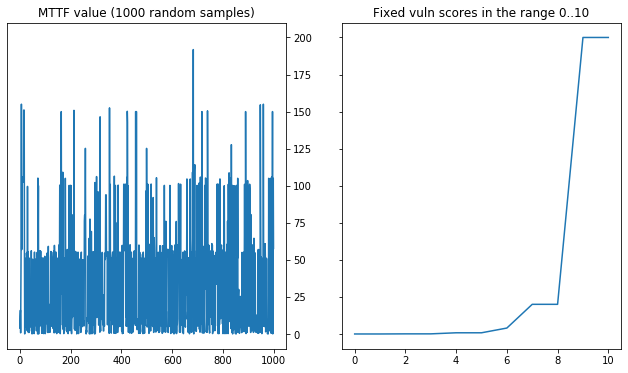

In [14]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(11,6))


ax1.plot(df['value'])
ax1.set_title('MTTF value (1000 random samples)')
ax1.yaxis.tick_right()
# ax1.set_yticks([']) 

ax2.plot(df_fixed_cvss['value'])
ax2.set_title('Fixed vuln scores in the range 0..10')



So out of 1000 samples, our average time to compromise is ~34 weeks. 

### Functions for extracting data from graphs

In [15]:


def dot2adj(dot_str, weight='score', nodelist=None):
    """Reads a dot graph file, converts to adj matrix"""
    g = AttackGraph()
    g.load_dot_string(dot_str)
    nl  = nodelist
    if not nl:
        nl = list(nx.topological_sort(g))
#     print(g.nodes(), nl)
    A = np.squeeze(np.asarray(nx.to_numpy_matrix(g, nodelist=nl, weight=weight).flatten()))
#     print(A.shape, type(A))
    return A
    

def row2adj(dot_str_row, dotcol='reduced_ag', weight='score', nodelist=None):
    """Reads a dot graph file, converts to adj matrix"""
    g = None
    if dotcol == 'fact_graph':
        g = FactGraph()
    else:
        g = AttackGraph()
    g.load_dot_string(dot_str_row[dotcol])
    nl  = nodelist
    if not nl:
        nl = list(nx.topological_sort(g))
#     print(g.nodes(), nl)
    A = np.squeeze(np.asarray(nx.to_numpy_matrix(g, nodelist=nl, weight=weight).flatten()))
#     print(A.shape, type(A))
    x =  A.tolist() # :/ 
    y = [dot_str_row.sample_uri] + x +[dot_str_row.value]
#     print(type(y), y)
    return y


def flatNodeList(nodelist):
    fnl = []
    for i in range(len(nodelist)):
        for j in range(len(nodelist)):
            fnl.append('w_{}_{}'.format(i,j))
    return fnl
    
    

In [16]:
df.head()

,sample_uri,reduced_ag,value,orig_ag,fact_graph,metric
0,f3c1b87e-cad1-431f-ac63-eac72b694c84,digraph single_host_1 {\n\tgraph [name=single_...,4.00,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
1,0514df06-4242-451a-b737-41057c26dc00,digraph single_host_1 {\n\tgraph [name=single_...,12.00,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
2,a6c94818-2807-484a-83c5-d2f227a37a45,digraph single_host_1 {\n\tgraph [name=single_...,16.00,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
3,8b265a5c-f662-42fd-a8a1-f084ef4a66e1,digraph single_host_1 {\n\tgraph [name=single_...,0.75,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf
4,9dc8f994-84a6-40d4-ae6d-bf1cfdba007d,digraph single_host_1 {\n\tgraph [name=single_...,40.50,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",mttf


### Load a graph from db

In [17]:
ag_reduced = AttackGraph()
dots = df['reduced_ag'].values[0]
ag_reduced.load_dot_string(dots)
nodelist = list(nx.topological_sort(ag_reduced))
# print(nodelist)
fnl = flatNodeList(nodelist)
print(fnl)
# print(dots)
a = dot2adj(dots, weight='score_orig')
# print(type(a), a)




['w_0_0', 'w_0_1', 'w_0_2', 'w_0_3', 'w_0_4', 'w_0_5', 'w_1_0', 'w_1_1', 'w_1_2', 'w_1_3', 'w_1_4', 'w_1_5', 'w_2_0', 'w_2_1', 'w_2_2', 'w_2_3', 'w_2_4', 'w_2_5', 'w_3_0', 'w_3_1', 'w_3_2', 'w_3_3', 'w_3_4', 'w_3_5', 'w_4_0', 'w_4_1', 'w_4_2', 'w_4_3', 'w_4_4', 'w_4_5', 'w_5_0', 'w_5_1', 'w_5_2', 'w_5_3', 'w_5_4', 'w_5_5']


### Create training set

In [18]:

cols= ['sample_uri'] + fnl + ["score"]
df_fnl =  df.apply(lambda row: row2adj(row, dotcol='reduced_ag', weight='score_orig', nodelist=nodelist) , axis='columns' , result_type='expand')
df_fnl.columns = cols
print(df_fnl.shape)
print(df_fnl.head())



(1000, 38)
                             sample_uri  w_0_0  w_0_1  w_0_2  w_0_3  w_0_4  \
0  f3c1b87e-cad1-431f-ac63-eac72b694c84    0.0   5.49    0.0    0.0    0.0   
1  0514df06-4242-451a-b737-41057c26dc00    0.0   7.74    0.0    0.0    0.0   
2  a6c94818-2807-484a-83c5-d2f227a37a45    0.0   6.21    0.0    0.0    0.0   
3  8b265a5c-f662-42fd-a8a1-f084ef4a66e1    0.0   2.05    0.0    0.0    0.0   
4  9dc8f994-84a6-40d4-ae6d-bf1cfdba007d    0.0   7.00    0.0    0.0    0.0   

   w_0_5  w_1_0  w_1_1  w_1_2  ...  w_4_3  w_4_4  w_4_5  w_5_0  w_5_1  w_5_2  \
0    0.0    0.0    0.0   5.81  ...    0.0    0.0   5.07    0.0    0.0    0.0   
1    0.0    0.0    0.0   5.21  ...    0.0    0.0   6.43    0.0    0.0    0.0   
2    0.0    0.0    0.0   1.85  ...    0.0    0.0   8.10    0.0    0.0    0.0   
3    0.0    0.0    0.0   5.71  ...    0.0    0.0   4.82    0.0    0.0    0.0   
4    0.0    0.0    0.0   9.67  ...    0.0    0.0   7.84    0.0    0.0    0.0   

   w_5_3  w_5_4  w_5_5  score  
0    0.

## ML Experiments

In [19]:


import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
#from sklearn.model_selection import train_test_split



def pretty_print_linear(coefs, names = None, sort = False):
    if names is None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name) for coef, name in lst)

def load_data():
    X = df_fnl[fnl]
    Y = df_fnl['score']
    names = fnl
    print('X:', X.shape)
    print('Y:',Y.shape)
    print('names:', len(names))
    return X,Y,names

def scale_data(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X


def split_data(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    return X_train, X_test, Y_train, Y_test


def root_mean_square_error(y_pred,y_test):
    rmse_train = np.sqrt(np.dot(abs(y_pred-y_test),abs(y_pred-y_test))/len(y_test))
    return rmse_train

def plot_real_vs_predicted(y_pred,y_test):
    plt.plot(y_pred,y_test,'ro')
    plt.plot([0,50],[0,50], 'g-')
    plt.xlabel('predicted')
    plt.ylabel('real')
    plt.show()
    return plt

def generate_regression_values(model, X, y):
    params = np.append(model.intercept_, model.coef_)
    predictions = model.predict(X)
    newX = pd.DataFrame({"Constant": np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y - predictions) ** 2)) / (len(newX) - len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE * (np.linalg.inv(np.dot(newX.T, newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params / sd_b

    p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

    sd_b = np.round(sd_b, 3)
    ts_b = np.round(ts_b, 3)
    p_values = np.round(p_values, 3)
    params = np.round(params, 4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"], myDF3["Standard Errors"], myDF3["t values"], myDF3[
        "Probabilites"
    ] = [params, sd_b, ts_b, p_values]
    print(myDF3)


### Embeddings

In [20]:
X, Y, names = load_data()

X: (1000, 36)
Y: (1000,)
names: 36


In [22]:
X.describe()

,w_0_0,w_0_1,w_0_2,w_0_3,w_0_4,w_0_5,w_1_0,w_1_1,w_1_2,w_1_3,...,w_4_2,w_4_3,w_4_4,w_4_5,w_5_0,w_5_1,w_5_2,w_5_3,w_5_4,w_5_5
count,1000.0,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.000000,1000.00000,...,1000.0,1000.0,1000.0,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,0.0,4.940850,0.0,0.0,0.0,0.0,0.0,0.0,5.121110,5.09931,...,0.0,0.0,0.0,5.032080,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,2.875171,0.0,0.0,0.0,0.0,0.0,0.0,2.856995,2.85285,...,0.0,0.0,0.0,2.894216,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.02000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,2.527500,0.0,0.0,0.0,0.0,0.0,0.0,2.607500,2.58000,...,0.0,0.0,0.0,2.580000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,4.835000,0.0,0.0,0.0,0.0,0.0,0.0,5.115000,5.24000,...,0.0,0.0,0.0,5.015000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,7.427500,0.0,0.0,0.0,0.0,0.0,0.0,7.592500,7.50250,...,0.0,0.0,0.0,7.630000,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,9.990000,0.0,0.0,0.0,0.0,0.0,0.0,9.980000,10.00000,...,0.0,0.0,0.0,9.990000,0.0,0.0,0.0,0.0,0.0,0.0
